In [1]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data import DataLoader

device = 'cuda'
transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

datasets = {
    'train': MNIST(root='data', train=True, download=True, transform=transform),
    'test': MNIST(root='data', train=False, download=True, transform=transform)
}

loaders = {
    'train': DataLoader(dataset=datasets['train'],batch_size=64,shuffle=True, pin_memory=True, pin_memory_device=device, num_workers=4),
    'test': DataLoader(dataset=datasets['test'],batch_size=64,shuffle=False, pin_memory=True, pin_memory_device=device, num_workers=4)
}

In [2]:
from torch import Tensor
from torch.nn import Module
from torch.nn import Flatten,  Sequential
from torch.nn import Linear, ReLU, Dropout
from model.dropconnect import DropConnectLinear, DropConnectBatchAverage

class Perceptron(Module):
    def __init__(self, input_features: int, hidden_dimension: int, output_features: int, p: float):
        super().__init__()
        self.flatten = Flatten()
        self.layers = Sequential(
            Linear(input_features, hidden_dimension),
            ReLU(),
            Dropout(p),
            Linear(hidden_dimension, output_features),
        )

    def forward(self, input: Tensor) -> Tensor:
        input = self.flatten(input)
        return self.layers(input)
            

class DropConnectPerceptron(Module):
    def __init__(self, input_features: int, hidden_dimension: int, output_features: int, p: float):
        super().__init__()
        self.flatten = Flatten()
        self.layers = Sequential(
            DropConnectLinear(input_features, hidden_dimension, p=p),
            ReLU(),
            DropConnectBatchAverage(),
            DropConnectLinear(hidden_dimension, output_features, p=p),
            ReLU(),
            DropConnectBatchAverage()
        )

    def forward(self, input: Tensor) -> Tensor:
        input = self.flatten(input)
        return self.layers(input)

In [3]:
from utils import run
from metrics import Summary

import torch
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
torch.set_float32_matmul_precision('high')   

First results!

Running experiment Perceptron with id 5fb9ad2f-5e98-49ce-93cd-3a2f324ec6bf
Tensorboard logs are saved in logs/Perceptron-5fb9ad2f-5e98-49ce-93cd-3a2f324ec6bf
Run tensorboard with: tensorboard --logdir=logs/
Open browser and go to: http://localhost:6006/
----------------------------------------------------------------
model: OptimizedModule(
  (_orig_mod): Perceptron(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=512, out_features=10, bias=True)
    )
  )
)
----------------------------------------------------------------
optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
----------------------------------------------------------------
criterion: CrossEntropy

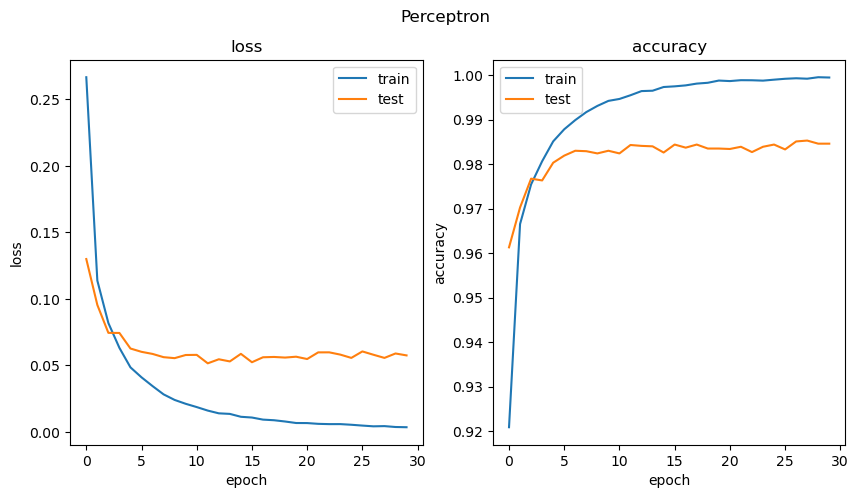

Running experiment DropConnectPerceptron with id 5fb9ad2f-5e98-49ce-93cd-3a2f324ec6bf
Tensorboard logs are saved in logs/DropConnectPerceptron-5fb9ad2f-5e98-49ce-93cd-3a2f324ec6bf
Run tensorboard with: tensorboard --logdir=logs/
Open browser and go to: http://localhost:6006/
----------------------------------------------------------------
model: OptimizedModule(
  (_orig_mod): DropConnectPerceptron(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (layers): Sequential(
      (0): DropConnectLinear(in_features=784, out_features=512, bias=True, p=0.2, max_batch_size=512)
      (1): ReLU()
      (2): DropConnectBatchAverage()
      (3): DropConnectLinear(in_features=512, out_features=10, bias=True, p=0.2, max_batch_size=512)
      (4): ReLU()
      (5): DropConnectBatchAverage()
    )
  )
)
----------------------------------------------------------------
optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maxi

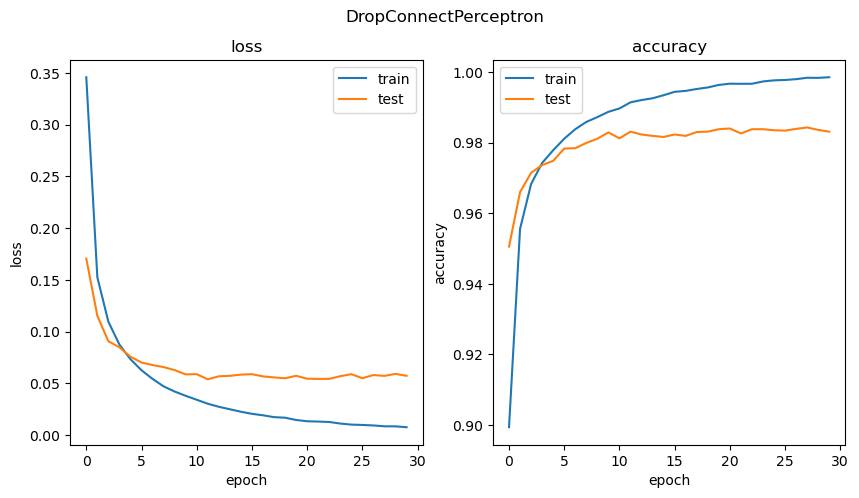

In [4]:
from uuid import uuid4
experiment = uuid4()

model = Perceptron(784, 512, 10, p=0.2).to(device)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = CrossEntropyLoss()
compiled = torch.compile(model)

summary = Summary(name=model.__class__.__name__, id=experiment)
run(compiled, optimizer, criterion, device, loaders, summary, epochs=30)

model = DropConnectPerceptron(784, 512, 10, p=0.2).to(device)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = CrossEntropyLoss()
compiled = torch.compile(model)

summary = Summary(name=model.__class__.__name__, id=experiment)
run(compiled, optimizer, criterion, device, loaders, summary, epochs=30)

##### Experiment with id 5fb9ad2f-5e98-49ce-93cd-3a2f324ec6bf.

#### Results for perceptron:
- Average loss: 0.0034 (train), 0.0574 (test)
- Average accuracy: 0.9994 (train), 0.9846 (test)

#### Results for dropconnect:
- Average loss: 0.0075 (train), 0.0572 (test)
- Average accuracy: 0.9985 (train), 0.9831 (test)

Running experiment Perceptron with id 3be54797-85a4-44dd-8fb2-988ce9882932
Tensorboard logs are saved in logs/Perceptron-3be54797-85a4-44dd-8fb2-988ce9882932
Run tensorboard with: tensorboard --logdir=logs/
Open browser and go to: http://localhost:6006/
----------------------------------------------------------------
model: OptimizedModule(
  (_orig_mod): Perceptron(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=512, out_features=10, bias=True)
    )
  )
)
----------------------------------------------------------------
optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
----------------------------------------------------------------
criterion: CrossEntropy

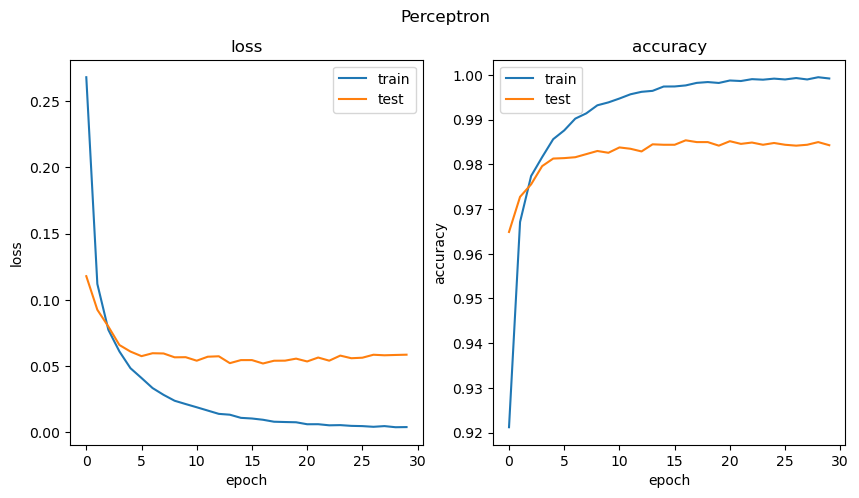

Running experiment DropConnectPerceptron with id 3be54797-85a4-44dd-8fb2-988ce9882932
Tensorboard logs are saved in logs/DropConnectPerceptron-3be54797-85a4-44dd-8fb2-988ce9882932
Run tensorboard with: tensorboard --logdir=logs/
Open browser and go to: http://localhost:6006/
----------------------------------------------------------------
model: OptimizedModule(
  (_orig_mod): DropConnectPerceptron(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (layers): Sequential(
      (0): DropConnectLinear(in_features=784, out_features=512, bias=True, p=0.2, max_batch_size=512)
      (1): ReLU()
      (2): DropConnectBatchAverage()
      (3): DropConnectLinear(in_features=512, out_features=10, bias=True, p=0.2, max_batch_size=512)
      (4): ReLU()
      (5): DropConnectBatchAverage()
    )
  )
)
----------------------------------------------------------------
optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maxi

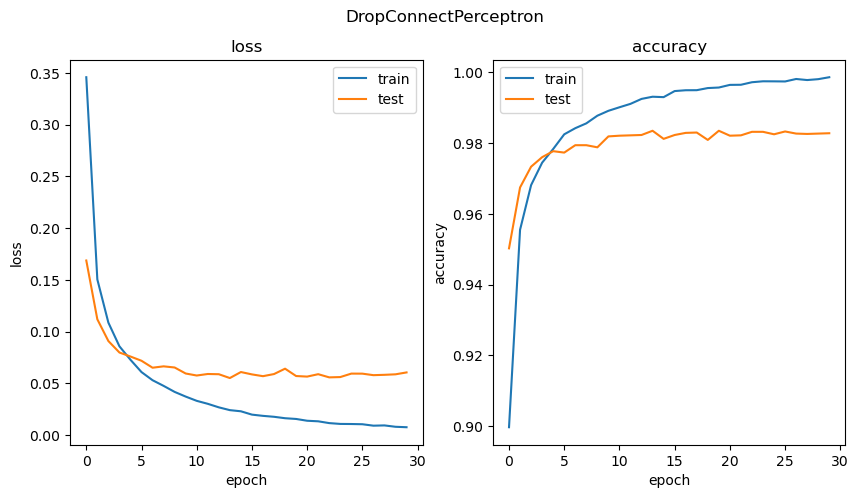

In [5]:
from uuid import uuid4
experiment = uuid4()

model = Perceptron(784, 512, 10, p=0.2).to(device)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = CrossEntropyLoss()
compiled = torch.compile(model)

summary = Summary(name=model.__class__.__name__, id=experiment)
run(compiled, optimizer, criterion, device, loaders, summary, epochs=30)

model = DropConnectPerceptron(784, 512, 10, p=0.2).to(device)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = CrossEntropyLoss()
compiled = torch.compile(model)

summary = Summary(name=model.__class__.__name__, id=experiment)
run(compiled, optimizer, criterion, device, loaders, summary, epochs=30)

##### Experiment with id 3be54797-85a4-44dd-8fb2-988ce9882932.

#### Results for perceptron:
- Average loss: 0.0039 (train), 0.0586 (test)
- Average accuracy: 0.9992 (train), 0.9843 (test)

#### Results for dropconnect:
- Average loss: 0.0075 (train), 0.0605 (test)
- Average accuracy: 0.9986 (train), 0.9828 (test)

Running experiment Perceptron with id 77da068d-4301-432a-9e67-cf1c4400e1e0
Tensorboard logs are saved in logs/Perceptron-77da068d-4301-432a-9e67-cf1c4400e1e0
Run tensorboard with: tensorboard --logdir=logs/
Open browser and go to: http://localhost:6006/
----------------------------------------------------------------
model: OptimizedModule(
  (_orig_mod): Perceptron(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=512, out_features=10, bias=True)
    )
  )
)
----------------------------------------------------------------
optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
----------------------------------------------------------------
criterion: CrossEntropy

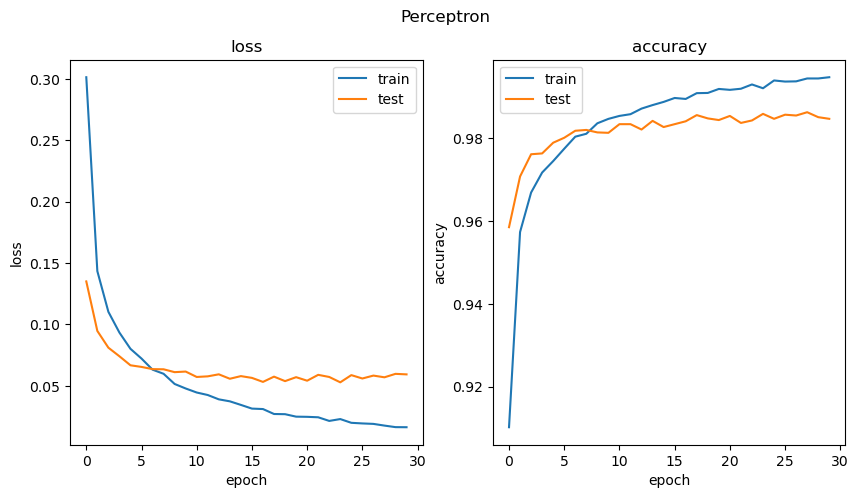

Running experiment DropConnectPerceptron with id 77da068d-4301-432a-9e67-cf1c4400e1e0
Tensorboard logs are saved in logs/DropConnectPerceptron-77da068d-4301-432a-9e67-cf1c4400e1e0
Run tensorboard with: tensorboard --logdir=logs/
Open browser and go to: http://localhost:6006/
----------------------------------------------------------------
model: OptimizedModule(
  (_orig_mod): DropConnectPerceptron(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (layers): Sequential(
      (0): DropConnectLinear(in_features=784, out_features=512, bias=True, p=0.5, max_batch_size=512)
      (1): ReLU()
      (2): DropConnectBatchAverage()
      (3): DropConnectLinear(in_features=512, out_features=10, bias=True, p=0.5, max_batch_size=512)
      (4): ReLU()
      (5): DropConnectBatchAverage()
    )
  )
)
----------------------------------------------------------------
optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maxi

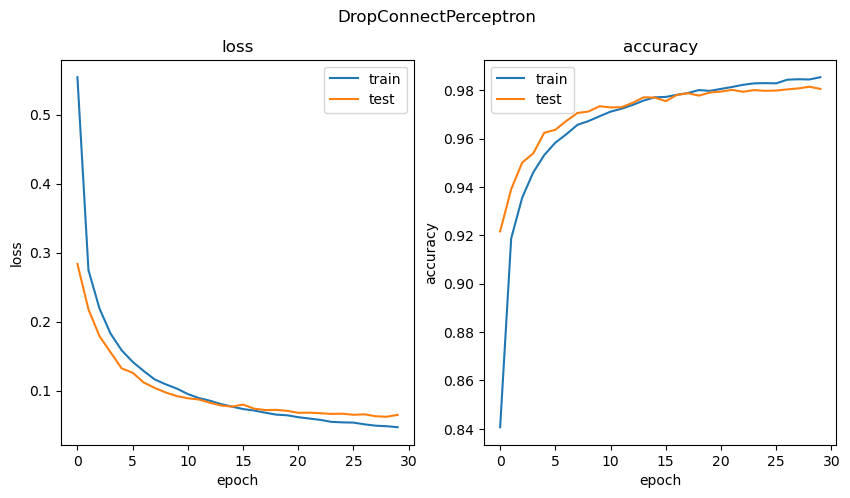

In [6]:
from uuid import uuid4
experiment = uuid4()

model = Perceptron(784, 512, 10, p=0.5).to(device)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = CrossEntropyLoss()
compiled = torch.compile(model)

summary = Summary(name=model.__class__.__name__, id=experiment)
run(compiled, optimizer, criterion, device, loaders, summary, epochs=30)

model = DropConnectPerceptron(784, 512, 10, p=0.5).to(device)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = CrossEntropyLoss()
compiled = torch.compile(model)

summary = Summary(name=model.__class__.__name__, id=experiment)
run(compiled, optimizer, criterion, device, loaders, summary, epochs=30)

##### Experiment with id 77da068d-4301-432a-9e67-cf1c4400e1e0.

#### Results for perceptron:
- Average loss: 0.0163 (train), 0.0594 (test)
- Average accuracy: 0.9947 (train), 0.9847 (test)

#### Results for dropconnect:
- Average loss: 0.0470 (train), 0.0649 (test)
- Average accuracy: 0.9854 (train), 0.9806 (test)

Running experiment Perceptron with id d1604d3a-2a7d-4c5d-8b78-a3d1aa6cc2d0
Tensorboard logs are saved in logs/Perceptron-d1604d3a-2a7d-4c5d-8b78-a3d1aa6cc2d0
Run tensorboard with: tensorboard --logdir=logs/
Open browser and go to: http://localhost:6006/
----------------------------------------------------------------
model: OptimizedModule(
  (_orig_mod): Perceptron(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=256, out_features=10, bias=True)
    )
  )
)
----------------------------------------------------------------
optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
----------------------------------------------------------------
criterion: CrossEntropy

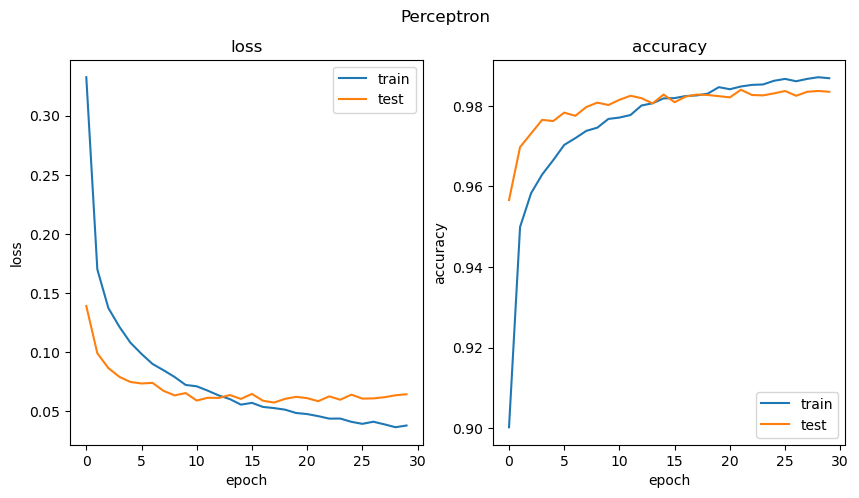

Running experiment DropConnectPerceptron with id d1604d3a-2a7d-4c5d-8b78-a3d1aa6cc2d0
Tensorboard logs are saved in logs/DropConnectPerceptron-d1604d3a-2a7d-4c5d-8b78-a3d1aa6cc2d0
Run tensorboard with: tensorboard --logdir=logs/
Open browser and go to: http://localhost:6006/
----------------------------------------------------------------
model: OptimizedModule(
  (_orig_mod): DropConnectPerceptron(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (layers): Sequential(
      (0): DropConnectLinear(in_features=784, out_features=256, bias=True, p=0.5, max_batch_size=512)
      (1): ReLU()
      (2): DropConnectBatchAverage()
      (3): DropConnectLinear(in_features=256, out_features=10, bias=True, p=0.5, max_batch_size=512)
      (4): ReLU()
      (5): DropConnectBatchAverage()
    )
  )
)
----------------------------------------------------------------
optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maxi

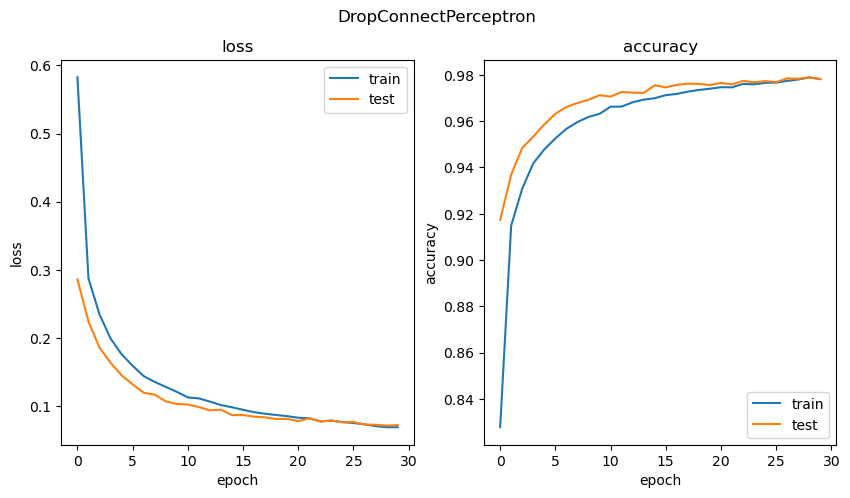

In [7]:
from uuid import uuid4
experiment = uuid4()

model = Perceptron(784, 256, 10, p=0.5).to(device)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = CrossEntropyLoss()
compiled = torch.compile(model)

summary = Summary(name=model.__class__.__name__, id=experiment)
run(compiled, optimizer, criterion, device, loaders, summary, epochs=30)

model = DropConnectPerceptron(784, 256, 10, p=0.5).to(device)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = CrossEntropyLoss()
compiled = torch.compile(model)

summary = Summary(name=model.__class__.__name__, id=experiment)
run(compiled, optimizer, criterion, device, loaders, summary, epochs=30)

##### Experiment with id d1604d3a-2a7d-4c5d-8b78-a3d1aa6cc2d0

#### Results for perceptron:
- Average loss: 0.0382 (train), 0.0645 (test)
- Average accuracy: 0.9868 (train), 0.9835 (test)

#### Results for dropconnect:
- Average loss: 0.0687 (train), 0.0718 (test)
- Average accuracy: 0.9782 (train), 0.9782 (test)

TODO:
- More epochs are needed. 
- Different batch sizes and learning rates will be tested.
- Different architectures will be tested.